# Imports

In [12]:
# Python standard library
import glob
import os

# Third-party libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Local python files
from path_constants import FIGURE_FOLDER, DATA_FOLDER
from nb_utils import describe
from plot_constants import (
    PROTEIN_COLOR,
    DAYHOFF_COLOR,
    PEPTIDE_MOLTYPE_PALETTE,
    PEPTIDE_MOLTYPE_ORDER,
    PEPTIDE_ALPHABET_KSIZES,
    PEPTIDE_ALPHABET_PALETTES,
)
from mya_utils import (
    clean_common_names_of_species,
    BUSCO_MAMMALIA_SPECIES,
    MYA_COLOR_KWARGS,
    MYA_ORDER,
)

## Get number of protein sequences per species

In [4]:
proteome_folder = os.path.join(
    DATA_FOLDER, "orpheum-benchmarking", "mammalia_busco_subsets"
)

busco_mammalia_species = BUSCO_MAMMALIA_SPECIES.copy()

col = "proteome_size"
busco_mammalia_species[col] = 0
for fasta in glob.glob(os.path.join(proteome_folder, "*.fasta")):
    species_lower = os.path.basename(fasta).split("__")[-1].split(".")[0]
    proteome_size = sum(1 for _ in screed.open(fasta))

    busco_mammalia_species.loc[species_lower, col] = proteome_size
busco_mammalia_species = busco_mammalia_species.sort_values("mya")
describe(busco_mammalia_species)

(18, 4)
--- First 5 entries ---


,common_name,scientific_name,mya,proteome_size
scientific_lower,,,,
homo_sapiens,human,Homo sapiens,0.0,15066
macaca_mulatta,macaque,Macaca mulatta,29.4,5008
aotus_nancymaae,night monkey,Aotus nancymaae,43.2,7261
tupaia_chinensis,tupaia,Tupaia chinensis,82.0,1338
mus_musculus,house mouse,Mus musculus,90.0,14519


## Reindex BUSCO mammalia series to use common name

In [5]:
busco_mammalia_common = busco_mammalia_species.reset_index().set_index('common_name')

## Read ROC AUC csv

In [6]:
csv = os.path.join(
    DATA_FOLDER,
    "orpheum-benchmarking",
    "busco_mammalia_coding_scores_roc_auc_score.csv",
)


combined_roc_auc_score = pd.read_csv(csv)
# combined_roc_auc_score = combined_roc_auc_score.join(distance_from_human_mya, on='species')

combined_roc_auc_score.species = combined_roc_auc_score.species.map(
    clean_common_names_of_species
)
# Everything decreases after k > 21
combined_roc_auc_score = combined_roc_auc_score.query("ksize <= 21")
combined_roc_auc_score = combined_roc_auc_score.join(
    busco_mammalia_common, on="species"
)
combined_roc_auc_score.head()

,species,alphabet,ksize,score_value,score_name,scientific_lower,scientific_name,mya,proteome_size
0,baiji,dayhoff,5,0.397805,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
1,baiji,dayhoff,6,0.363173,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
2,baiji,dayhoff,7,0.363950,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
3,baiji,dayhoff,8,0.385517,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
4,baiji,dayhoff,9,0.418185,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8


In [7]:
max_roc_scores = combined_roc_auc_score.groupby(
    ['species', 'alphabet']).score_value.max()
max_roc_scores.name = 'max_roc_auc'
max_roc_scores = max_roc_scores.reset_index()
max_roc_scores = max_roc_scores.join(busco_mammalia_common, on='species')
describe(max_roc_scores)

(36, 7)
--- First 5 entries ---


,species,alphabet,max_roc_auc,scientific_lower,scientific_name,mya,proteome_size
0,baiji,dayhoff,0.500255,lipotes_vexillifer,Lipotes vexillifer,96.0,8
1,baiji,protein,0.500607,lipotes_vexillifer,Lipotes vexillifer,96.0,8
2,bat,dayhoff,0.552860,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1
3,bat,protein,0.503737,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1
4,camel,dayhoff,0.500110,camelus_bactrianus,Camelus bactrianus,96.0,4


In [8]:
max_roc_scores.query('max_roc_auc > 0.6')

,species,alphabet,max_roc_auc,scientific_lower,scientific_name,mya,proteome_size
14,hedgehog,dayhoff,0.869341,erinaceus_europaeus,Erinaceus europaeus,96.0,13448
15,hedgehog,protein,0.929230,erinaceus_europaeus,Erinaceus europaeus,96.0,13448
16,house mouse,dayhoff,0.880976,mus_musculus,Mus musculus,90.0,14519
17,house mouse,protein,0.938552,mus_musculus,Mus musculus,90.0,14519
18,human,dayhoff,0.996881,homo_sapiens,Homo sapiens,0.0,15066
19,human,protein,0.998456,homo_sapiens,Homo sapiens,0.0,15066
22,macaque,dayhoff,0.770334,macaca_mulatta,Macaca mulatta,29.4,5008
23,macaque,protein,0.789053,macaca_mulatta,Macaca mulatta,29.4,5008
24,night monkey,dayhoff,0.818646,aotus_nancymaae,Aotus nancymaae,43.2,7261
25,night monkey,protein,0.844914,aotus_nancymaae,Aotus nancymaae,43.2,7261


# SFig 1G

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/seaborn/axisgrid.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(**kwargs)


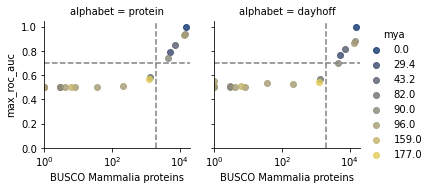

In [10]:
g = sns.lmplot(
    x="proteome_size",
    y="max_roc_auc",
    col="alphabet",
    col_order=["protein", "dayhoff"],
    data=max_roc_scores,
    height=2.5,
    fit_reg=False,
    **MYA_COLOR_KWARGS
)
g.set(ylim=(0, 1.05), xlim=(-10, 2e4), xlabel="BUSCO Mammalia proteins", xscale="log")
for ax in g.axes.flat:
    ax.axhline(0.7, linestyle="--", color="grey")
    ax.axvline(2000, linestyle="--", color="grey")
pdf = os.path.join(FIGURE_FOLDER, "orpheum_translate__proteome_size_vs_max_roc_auc.pdf")
g.savefig(pdf)

In [13]:
combined_roc_auc_score_dayhoff17_protein8 = combined_roc_auc_score.query('(alphabet == "dayhoff" and ksize == 17) or (alphabet == "protein" and ksize == 8)')
describe(combined_roc_auc_score_dayhoff17_protein8)

(36, 9)
--- First 5 entries ---


,species,alphabet,ksize,score_value,score_name,scientific_lower,scientific_name,mya,proteome_size
12,baiji,dayhoff,17,0.499700,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
30,baiji,protein,8,0.500530,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
66,bat,dayhoff,17,0.499999,roc_auc,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1
84,bat,protein,8,0.500009,roc_auc,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1
120,camel,dayhoff,17,0.500095,roc_auc,camelus_bactrianus,Camelus bactrianus,96.0,4


In [14]:
combined_roc_auc_score_dayhoff17_protein8.query('proteome_size > 2000').groupby(['alphabet', 'mya']).score_value.mean()

alphabet  mya 
dayhoff   0.0     0.996881
          29.4    0.770334
          43.2    0.818646
          90.0    0.787676
          96.0    0.860161
protein   0.0     0.998456
          29.4    0.789053
          43.2    0.844914
          90.0    0.840868
          96.0    0.929230
Name: score_value, dtype: float64

### @paper plot correlation of proteom size to ROC auc

In [18]:
combined_roc_auc_score_dayhoff17_protein8.head()

,species,alphabet,ksize,score_value,score_name,scientific_lower,scientific_name,mya,proteome_size
12,baiji,dayhoff,17,0.499700,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
30,baiji,protein,8,0.500530,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
66,bat,dayhoff,17,0.499999,roc_auc,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1
84,bat,protein,8,0.500009,roc_auc,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1
120,camel,dayhoff,17,0.500095,roc_auc,camelus_bactrianus,Camelus bactrianus,96.0,4


In [19]:
combined_roc_auc_score_dayhoff17_protein8_corr = combined_roc_auc_score_dayhoff17_protein8.groupby('alphabet').corr(method='spearman')
combined_roc_auc_score_dayhoff17_protein8_corr

ksize  score_value       mya  proteome_size
alphabet                                                           
dayhoff  ksize            NaN          NaN       NaN            NaN
         score_value      NaN     1.000000 -0.525680       0.922921
         mya              NaN    -0.525680  1.000000      -0.414951
         proteome_size    NaN     0.922921 -0.414951       1.000000
protein  ksize            NaN          NaN       NaN            NaN
         score_value      NaN     1.000000 -0.439679       0.989139
         mya              NaN    -0.439679  1.000000      -0.414951
         proteome_size    NaN     0.989139 -0.414951       1.000000

# SFig 1D

### MYA vs ROC 

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


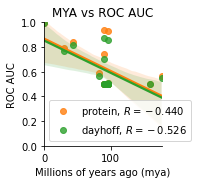

In [23]:
protein_mya_roc_corr = combined_roc_auc_score_dayhoff17_protein8_corr.loc[
    ("protein", "mya"), "score_value"
]
dayhoff_mya_roc_corr = combined_roc_auc_score_dayhoff17_protein8_corr.loc[
    ("dayhoff", "mya"), "score_value"
]

mya_roc_corrs = {"protein": protein_mya_roc_corr, "dayhoff": dayhoff_mya_roc_corr}

g = sns.lmplot(
    data=combined_roc_auc_score_dayhoff17_protein8,
    x="mya",
    y="score_value",
    hue="alphabet",
    palette=PEPTIDE_MOLTYPE_PALETTE,
    hue_order=PEPTIDE_MOLTYPE_ORDER,
    size=2.25,
    legend=False
)
for ax in g.axes.flat:
    h, l = ax.get_legend_handles_labels()
    labels = [f'{x}, $R={mya_roc_corrs[x]:.3f}$' for x in l]
    ax.legend(h, labels)


g.set(title=('MYA vs ROC AUC'), ylabel='ROC AUC', xlabel='Millions of years ago (mya)')
pdf = os.path.join(
    FIGURE_FOLDER,
    f"orpheum_translate__lmplot__mya_vs_roc-auc.pdf",
)
g.set(ylim=(0, 1))
g.savefig(pdf)

In [24]:
pdf

'../figures/orpheum_translate__lmplot__mya_vs_roc-auc.pdf'

# SFig 1F

### Number of proteins vs ROC

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


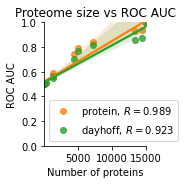

In [25]:
protein_n_proteins_roc_corr = combined_roc_auc_score_dayhoff17_protein8_corr.loc[
    ("protein", "proteome_size"), "score_value"
]
dayhoff_n_proteins_roc_corr = combined_roc_auc_score_dayhoff17_protein8_corr.loc[
    ("dayhoff", "proteome_size"), "score_value"
]

n_proteins_roc_corrs = {"protein": protein_n_proteins_roc_corr, "dayhoff": dayhoff_n_proteins_roc_corr}

g = sns.lmplot(
    data=combined_roc_auc_score_dayhoff17_protein8,
    x="proteome_size",
    y="score_value",
    hue="alphabet",
    palette=PEPTIDE_MOLTYPE_PALETTE,
    hue_order=PEPTIDE_MOLTYPE_ORDER,
    size=2.25,
    legend=False,
)


for ax in g.axes.flat:
    h, l = ax.get_legend_handles_labels()
    labels = [f'{x}, $R={n_proteins_roc_corrs[x]:.3f}$' for x in l]
    ax.legend(h, labels)

g.set(title=('Proteome size vs ROC AUC'), ylabel='ROC AUC', xlabel='Number of proteins')
g.set(ylim=(0, 1))
pdf = os.path.join(
    FIGURE_FOLDER,
    f"orpheum_translate__lmplot__mya_vs_proteome-size.pdf",
)
g.savefig(pdf)

### @paper kmer complexity

## Get k-mer complexity per species

In [29]:
csv = os.path.join(
    DATA_FOLDER, "orpheum-benchmarking", "busco_mammalia_kmer_complexity.csv"
)

kmer_complexity = pd.read_csv(csv)
kmer_complexity["moltype"] = kmer_complexity.molecule.str.strip("0123456789")
kmer_complexity = kmer_complexity.join(busco_mammalia_species, on="name")
kmer_complexity

,name,molecule,ksize,sigma,expected_collisions,n_unique_kmers,n_theoretical_kmers_log10,n_unique_kmers_log10,unique_over_theoretical_log10,moltype,common_name,scientific_name,mya,proteome_size
0,tupaia_chinensis,dayhoff6,17,6,6.506573e-10,506371,13.228571,5.704469,-7.524102,dayhoff,tupaia,Tupaia chinensis,82.0,1338
1,tupaia_chinensis,protein20,8,20,7.144468e-10,518316,10.408240,5.714595,-4.693645,protein,tupaia,Tupaia chinensis,82.0,1338
2,camelus_bactrianus,dayhoff6,17,6,2.747611e-21,724,13.228571,2.859739,-10.368833,dayhoff,camel,Camelus bactrianus,96.0,4
3,camelus_bactrianus,protein20,8,20,3.197955e-21,752,10.408240,2.876218,-7.532022,protein,camel,Camelus bactrianus,96.0,4
4,mus_musculus,dayhoff6,17,6,7.880357e-06,5443866,13.228571,6.735907,-6.492664,dayhoff,house mouse,Mus musculus,90.0,14519
5,mus_musculus,protein20,8,20,8.231361e-06,5505061,10.408240,6.740762,-3.667478,protein,house mouse,Mus musculus,90.0,14519
6,lipotes_vexillifer,dayhoff6,17,6,1.911689e-19,2091,13.228571,3.320354,-9.908217,dayhoff,baiji,Lipotes vexillifer,96.0,8
7,lipotes_vexillifer,protein20,8,20,2.188906e-19,2163,10.408240,3.335057,-7.073183,protein,baiji,Lipotes vexillifer,96.0,8
8,capra_hircus,dayhoff6,17,6,3.281257e-13,75724,13.228571,4.879234,-8.349338,dayhoff,goat,Capra hircus,96.0,213
9,capra_hircus,protein20,8,20,3.585962e-13,77413,10.408240,4.888814,-5.519426,protein,goat,Capra hircus,96.0,213


In [30]:
kmer_complexity_roc_scores = kmer_complexity.merge(
    combined_roc_auc_score_dayhoff17_protein8[["species", "alphabet", "score_value"]],
    left_on=["common_name", "moltype"],
    right_on=["species", "alphabet"],
)
kmer_complexity_roc_scores.head()

,name,molecule,ksize,sigma,expected_collisions,n_unique_kmers,n_theoretical_kmers_log10,n_unique_kmers_log10,unique_over_theoretical_log10,moltype,common_name,scientific_name,mya,proteome_size,species,alphabet,score_value
0,tupaia_chinensis,dayhoff6,17,6,6.506573e-10,506371,13.228571,5.704469,-7.524102,dayhoff,tupaia,Tupaia chinensis,82.0,1338,tupaia,dayhoff,0.567616
1,tupaia_chinensis,protein20,8,20,7.144468e-10,518316,10.408240,5.714595,-4.693645,protein,tupaia,Tupaia chinensis,82.0,1338,tupaia,protein,0.586537
2,camelus_bactrianus,dayhoff6,17,6,2.747611e-21,724,13.228571,2.859739,-10.368833,dayhoff,camel,Camelus bactrianus,96.0,4,camel,dayhoff,0.500095
3,camelus_bactrianus,protein20,8,20,3.197955e-21,752,10.408240,2.876218,-7.532022,protein,camel,Camelus bactrianus,96.0,4,camel,protein,0.500168
4,mus_musculus,dayhoff6,17,6,7.880357e-06,5443866,13.228571,6.735907,-6.492664,dayhoff,house mouse,Mus musculus,90.0,14519,house mouse,dayhoff,0.872079


In [31]:
kmer_complexity_roc_scores_corr = kmer_complexity_roc_scores.groupby('alphabet')[['score_value', 'n_unique_kmers', 'n_unique_kmers_log10']].corr(method='spearman')
kmer_complexity_roc_scores_corr

score_value  n_unique_kmers  \
alphabet                                                     
dayhoff  score_value              1.000000        0.923633   
         n_unique_kmers           0.923633        1.000000   
         n_unique_kmers_log10     0.923633        1.000000   
protein  score_value              1.000000        0.966976   
         n_unique_kmers           0.966976        1.000000   
         n_unique_kmers_log10     0.966976        1.000000   

                               n_unique_kmers_log10  
alphabet                                             
dayhoff  score_value                       0.923633  
         n_unique_kmers                    1.000000  
         n_unique_kmers_log10              1.000000  
protein  score_value                       0.966976  
         n_unique_kmers                    1.000000  
         n_unique_kmers_log10              1.000000

# SFig 1E

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


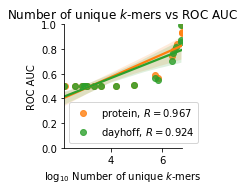

In [34]:
protein_kmer_roc_corr = kmer_complexity_roc_scores_corr.loc[('protein', 'score_value'), 'n_unique_kmers_log10']
dayhoff_kmer_roc_corr = kmer_complexity_roc_scores_corr.loc[('dayhoff', 'score_value'), 'n_unique_kmers_log10']
kmer_roc_corrs = {'protein': protein_kmer_roc_corr, 'dayhoff': dayhoff_kmer_roc_corr}

g = sns.lmplot(
    data=kmer_complexity_roc_scores,
    x="n_unique_kmers_log10",
    y="score_value",
    hue="alphabet",
    palette=PEPTIDE_MOLTYPE_PALETTE,
    hue_order=PEPTIDE_MOLTYPE_ORDER,
    size=2.25,
    legend=False,
)
g.set(title=('Number of unique $k$-mers vs ROC AUC'), xlabel='$\log_{10}$ Number of unique $k$-mers', ylabel='ROC AUC')
for ax in g.axes.flat:
    h, l = ax.get_legend_handles_labels()
    labels = [f'{x}, $R={kmer_roc_corrs[x]:.3f}$' for x in l]
    ax.legend(h, labels)
g.set(ylim=(0, 1))
pdf = os.path.join(
    FIGURE_FOLDER,
    f"orpheum_translate__lmplot__mya_vs_n_unique_kmers.pdf",
)
g.savefig(pdf)